In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:76% !important; }</style>"))

In [1]:
import os
import sys
import tensorflow as tf
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm
from pickle import (
    dump,
    load
)
from tensorflow.keras import (
    layers,
    Model,
    Sequential,
    optimizers
)
from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
BASE_DIR = "./"
DATA_FOLDER_NAME = "data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)
MODELS_FOLDER_NAME = "models"
MODELS_FOLDER_PATH = os.path.join(BASE_DIR, MODELS_FOLDER_NAME)
TUNERS_FOLDER_NAME = "tuners"
TUNERS_FOLDER_PATH = os.path.join(BASE_DIR, TUNERS_FOLDER_NAME)


OUTPUT_DATA_COLUMNS = ["position_x", "position_y", "position_z"]
INPUT_DATA_COLUMNS = ["angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                      "angular_velocity_x", "angular_velocity_y", "angular_velocity_z",
                      "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                      "linear_velocity_x", "linear_velocity_y", "linear_velocity_z",
                      "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                      "barometer_altitude", "barometer_pressure", "barometer_qnh", "barometer_timestamp",
                      "magnetometer_magnetic_field_body_x", "magnetometer_magnetic_field_body_y",
                      "magnetometer_magnetic_field_body_x", "magnetometer_timestamp",
                      "rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                      "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                      "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                      "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler",
                      "rotor_timestamp"
                     ]

TIMESTAMP_COLUMNS = [
    "motor_state_timestamp",
    "barometer_timestamp",
    "magnetometer_timestamp",
    "rotor_timestamp"
]


INPUT_SEQUENCE_COLUMNS = ["angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                          "barometer_altitude", "barometer_pressure", "barometer_qnh", "barometer_timestamp",
                          "magnetometer_magnetic_field_body_x", "magnetometer_magnetic_field_body_y",
                          "magnetometer_magnetic_field_body_x", "magnetometer_timestamp",
                          "rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                          "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                          "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                          "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler",
                          "rotor_timestamp"
                         ]
OUTPUT_SEQUENCE_COLUMNS = ["position_x", "position_y", "position_z"]
MAIN_TIMESTAMP_COLUMN = "motor_state_timestamp"
INPUT_SEQUENCE_LENGTH = 50


In [4]:
def save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "wb") as file:
        dump(model, file)

    with open(scaler_x_file_path, "wb") as file:
        dump(scaler_x, file)

    with open(scaler_y_file_path, "wb") as file:
        dump(scaler_y, file)
        
def load_model_with_scalers_binary(model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "rb") as file:
        model = load(file)

    with open(scaler_x_file_path, "rb") as file:
        scaler_x = load(file)

    with open(scaler_y_file_path, "rb") as file:
        scaler_y = load(file)

    return model, scaler_x, scaler_y

In [5]:
def split_data(data: np.array):
    """
    Splits data into train, dev and test
    :return:
    """
    data_len = len(data)

    train, dev, test = np.split(data, [int(.7 * data_len), int(.95 * data_len)])

    return train, dev, test


def _convert_timestamp_to_interval_seconds(flight_input_df: pd.DataFrame, timestamp_columns: list):
    """
    Converts the timestamp fields into the amount of seconds between each two timestamps

    Note: each timestamp represents the amount eof NANO seconds (1,000,000,000 nanoseconds = 1 seconds)
    """
    # Converts the start time to time interval
    next_time_df = flight_input_df[timestamp_columns].shift(-1)
    time_diff_df = (next_time_df - flight_input_df[timestamp_columns]) / 1_000_000_000
    flight_input_df.loc[:, timestamp_columns] = time_diff_df
    return flight_input_df


def _convert_location_to_step(flight_output_df: pd.DataFrame):
    next_coordinates_df = flight_output_df.shift(-1)
    coordinate_diff = flight_output_df - next_coordinates_df

    return coordinate_diff


def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)

    x_df = flight_df[input_columns].copy()
    timestamp_columns = [column for column in input_columns if column in TIMESTAMP_COLUMNS]
    x_df = _convert_timestamp_to_interval_seconds(x_df, timestamp_columns)

    y_df = flight_df[output_columns].copy()
    y_df = _convert_location_to_step(y_df)

    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    return x_df, y_df

In [69]:
def load_preprocessed_flight_sequences(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @param sequence_length: Target sequence length
    @return:
    """
    all_csv_files = os.listdir(DATA_FOLDER_PATH)

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    # The data feed to the rnn model
    sequences_x = []
    sequences_y = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df.to_numpy())
            y_sessions.append(y_df.to_numpy())

        except ValueError as error:
            print(str(error))

    all_x_data = np.concatenate(x_sessions)
    all_y_data = np.concatenate(y_sessions)

    # creating normalizers
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    #
#     scaler_x = StandardScaler()
#     scaler_y = StandardScaler()
    
    scaler_x.fit(all_x_data)
    scaler_y.fit(all_y_data)

    for session_data_x, session_data_y in zip(x_sessions, y_sessions):
        normalized_data_x = scaler_x.transform(session_data_x)
        normalized_data_y = scaler_y.transform(session_data_y)
#         normalized_data_y = np.add.accumulate(session_data_y)
        sequences_x.append(normalized_data_x)
        sequences_y.append(normalized_data_y)
        
    return sequences_x, sequences_y, scaler_x, scaler_y

def load_preprocessed_rnn_dataset(input_columns: list, output_columns: list):
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    flight_data_x, flight_data_y, scaler_x, scaler_y = load_preprocessed_flight_sequences(input_columns, output_columns)

#     flight_data_x = np.ndarray(flight_data_x, dtype="object")
#     flight_data_y = np.ndarray(flight_data_x, dtype="object")
    # flight_data_x, flight_data_y = shuffle_data_set(flight_data_x, flight_data_y)
    
    data_amount = len(flight_data_x)
    train_x = flight_data_x[:int(data_amount * .8)]
    dev_x = flight_data_x[int(data_amount * .8):]
    
    train_y = flight_data_y[:int(data_amount * .8)]
    dev_y = flight_data_y[int(data_amount * .8):]
    
    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y


In [70]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_rnn_dataset(INPUT_SEQUENCE_COLUMNS, OUTPUT_SEQUENCE_COLUMNS)


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0., 250.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([-0.02376592, -0.01376592, -0.00376592,  0.00623408,  0.01623408,
         0.02623408,  0.03623408,  0.04623408,  0.05623408,  0.06623408,
         0.07623408,  0.08623408,  0.09623408,  0.10623408,  0.11623408,
         0.12623408,  0.13623408,  0.14623408,  0.15623408,  0.16623408,
         0.17623408,  0.18

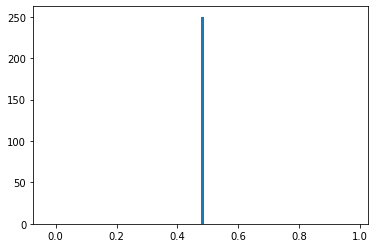

In [71]:
plt.hist(dev_y[0][:,0], 100)

In [72]:
def create_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    input_layer = layers.Input(shape=(None,input_columns_amount))
    layer = layers.LSTM(512, return_sequences=True)(input_layer)
    output_layer = layers.Dense(output_columns_amount)(layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.01))

    return model



def create_model_dynamic(hp: kt.HyperParameters) -> Model:
    """
    Creates LSTM model using the input hyperparameters chose by keras_tuner
    """
    input_layer = layers.Input(shape=(None, hp.get("input_columns_amount")))
    lstm_layer_1_units = hp.Int("lstm_layer_1_units", min_value=8, max_value=256, step=8)
    layer = layers.LSTM(lstm_layer_1_units, return_sequences=True)(input_layer)
    output_layer = layers.Dense(hp.get("output_columns_amount"))(layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.001, clipvalue=.5))

    return model

def create_model_dynamic(hp: kt.HyperParameters) -> Model:
    """
    Creates LSTM model using the input hyperparameters chose by keras_tuner
    """

    input_layer = layers.Input(shape=(None, hp.get("input_columns_amount")))
    lstm_layer_1_units = hp.Int("lstm_layer_units", min_value=8, max_value=128, step=8)
    layer = layers.LSTM(lstm_layer_1_units, return_sequences=True)(input_layer)
    
 
    dense_layers = hp.Int("dense_layers_amount", min_value=0, max_value=2)
    dense_activation = hp.Choice("dense_activation", ["sigmoid", "relu", "sigmoid", "relu", "tanh"])

    for layer_index in range(1, dense_layers + 1):
        units = hp.Int(f"dense_{layer_index}_units", min_value=16, max_value=128, step=16)
        layer = layers.Dense(units, activation=dense_activation)(layer)

        if hp.Boolean(f"dense_{layer_index}_dropout"):
            dropout_rate = hp.Float(f"dense_{layer_index}_dropout_rate", min_value=0, max_value=0.4, step=0.05)
            layer = layers.Dropout(dropout_rate)(layer)

    output_layer = layers.Dense(hp.get("output_columns_amount"))(layer)

    learning_rate = hp.Choice("adam_learning_rate", [0.1, 0.2, 0.05, 1e-2, 1e-3, 5e-3, 5e-4])
    if hp.Boolean(f"learning_rate_decay"):
        learning_rate = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000,
            decay_rate=0.9)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))
    
    return model
    

def train_epoch(epoch, model, train_x, train_y, dev_x, dev_y, **kwards):
    loss_temp = []
    for x, y in zip(train_x, train_y):
        train_loss = model.train_on_batch(np.expand_dims(x, axis=0),
                                          np.expand_dims(y, axis=0), **kwards)
        loss_temp.append(train_loss)
    
    train_loss = sum(loss_temp)/ len(loss_temp)
    
    loss_temp = []
    for x, y in zip(dev_x, dev_y):
        dev_loss = model.test_on_batch(np.expand_dims(x, axis=0),
                                       np.expand_dims(y, axis=0))
        loss_temp.append(dev_loss)
    
    dev_loss = sum(loss_temp)/ len(loss_temp)
    
    print(f"{epoch} loss: {train_loss}, val_loss: {dev_loss}")
    
    return train_loss, dev_loss

In [73]:
FORCE_CPU_RUN = False
if FORCE_CPU_RUN:
    print("###########################")
    tf.config.set_visible_devices([], 'GPU')

In [83]:
epochs = 100
model = create_model(len(INPUT_SEQUENCE_COLUMNS), len(OUTPUT_SEQUENCE_COLUMNS))

# model.summary()

all_train_loss = []
all_dev_loss = []
for epoch in range(epochs):
    loss_temp = []
    for x, y in zip(train_x, train_y):
        train_loss = model.train_on_batch(np.expand_dims(x, axis=0),
                                          np.expand_dims(y, axis=0))
        loss_temp.append(train_loss)

    train_loss = sum(loss_temp)/ len(loss_temp)
    all_train_loss.append(train_loss)
    
    loss_temp = []
    for x, y in zip(dev_x, dev_y):
        dev_loss = model.test_on_batch(np.expand_dims(x, axis=0),
                                       np.expand_dims(y, axis=0))
        loss_temp.append(dev_loss)
    
    val_loss = sum(loss_temp)/ len(loss_temp)
    all_dev_loss.append(val_loss)    
    
    print(f"{epoch} loss: {train_loss}, val_loss: {val_loss}")


# history = model.fit(train_x,
#           train_y,
#           epochs=100,
#           batch_size=1,
#           validation_data=(dev_x, dev_y))

0 loss: 2.8527215318264147, val_loss: 0.013864393532276153
1 loss: 0.015117746679798552, val_loss: 0.005833914782851934
2 loss: 0.013419166587195113, val_loss: 0.006934617180377245
3 loss: 0.012766976056522444, val_loss: 0.009764122311025858
4 loss: 0.015006562939992077, val_loss: 0.0149876169860363
5 loss: 0.017728343091316913, val_loss: 0.0208258006721735
6 loss: 0.020428896587538093, val_loss: 0.019326338451355694
7 loss: 0.02083722526501668, val_loss: 0.009906277153640985
8 loss: 0.016039103496280547, val_loss: 0.005338361067697406
9 loss: 0.010921170610297275, val_loss: 0.0046536476816982034
10 loss: 0.009095382882821324, val_loss: 0.004685049643740058
11 loss: 0.008972574086663755, val_loss: 0.0049416869413107635
12 loss: 0.009228018455599485, val_loss: 0.005199510417878628
13 loss: 0.009502022643573582, val_loss: 0.005451352242380381
14 loss: 0.009741514290094767, val_loss: 0.005728146340698004
15 loss: 0.009989902855044133, val_loss: 0.006086406297981739
16 loss: 0.010279509980

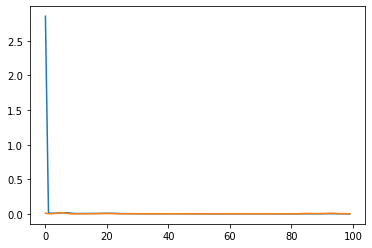

In [84]:
plt.plot(all_train_loss)
plt.plot(all_dev_loss) 


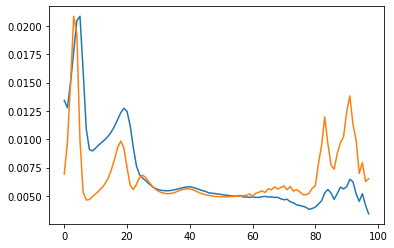

In [85]:
plt.plot(all_train_loss[2:])
plt.plot(all_dev_loss[2:]) 

In [86]:
save_model_with_scalers_binary(model, scaler_x, scaler_y, "s2s_model_static")

INFO:tensorflow:Assets written to: ram://01c3a8e1-5988-4008-96f8-25b04d3ad640/assets


INFO:tensorflow:Assets written to: ram://01c3a8e1-5988-4008-96f8-25b04d3ad640/assets


In [78]:
from settings import TUNERS_FOLDER_PATH
import copy 
class CusomeRandomTuner(kt.RandomSearch):
    def run_trial(self, trial, train_x, train_y, dev_x, dev_y, epochs, *args, **kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=self._get_checkpoint_fname(trial.trial_id, self._reported_step),
            monitor=self.oracle.objective.name,
            mode=self.oracle.objective.direction,
            save_best_only=True,
            save_weights_only=True,
        )
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor=self.oracle.objective.name,
                                                          patience=5, 
                                                          restore_best_weights=True)
        
        early_stopping.on_train_begin()
        
        model_checkpoint.set_model(model)
        early_stopping.set_model(model)
        best_loss = sys.float_info.max
        best_loss_index = 0
        
        histories = []
        for epoch in range(epochs):
            
            train_loss, dev_loss = train_epoch(epoch, model, train_x, train_y, dev_x, dev_y)
            scores = {'loss': train_loss, "val_loss": dev_loss}
            
            model_checkpoint.on_epoch_end(epoch, logs=scores) 
            early_stopping.on_epoch_end(epoch, logs=scores) 
            
            if dev_loss < best_loss:
                best_loss_index = epoch
                best_loss = dev_loss
                
            if model.stop_training:
                scores["val_loss"] = best_loss
                self.on_epoch_end(trial, model, epoch, logs=scores) 
                break
            elif epoch == epochs - 1:
                print(1)
                scores["val_loss"] = best_loss
            self.on_epoch_end(trial, model, epoch, logs=scores) 
            histories.append(scores)
        
        return histories


hp = kt.HyperParameters()
hp.Fixed("input_columns_amount", len(INPUT_SEQUENCE_COLUMNS))
hp.Fixed("output_columns_amount", len(OUTPUT_SEQUENCE_COLUMNS))

tuner = CusomeRandomTuner(
        create_model_dynamic,
        hyperparameters=hp,
        tune_new_entries=True,
        objective="val_loss",
        max_trials=1000,
        directory=TUNERS_FOLDER_PATH,
        project_name="s2s_exp1_2"
    )


In [79]:
model = tuner.get_best_models(num_models=10)[5]
save_model_with_scalers_binary(model, scaler_x, scaler_y, "s2s_model_1")

IndexError: list index out of range

In [ ]:
tuner.search(train_x = train_x,
             train_y = train_y,
             dev_x = dev_x,
             dev_y = dev_y,
             epochs = 100)

In [87]:
# evalueate test


def test_model_predictions(model_name: str, data_csv_name: str, input_columns: list, output_columns: list):
    flight_x_df, flight_y_df = load_flight_steps_from_file(data_csv_name, input_columns, output_columns)
    data_x = flight_x_df.to_numpy()
    real_y = flight_y_df.to_numpy()

    try:
        model, scaler_x, scaler_y = load_model_with_scalers_binary(model_name)
    except FileNotFoundError:
        print(f"There is no model in name: {model_name}")
        return
    
    print(model.test_on_batch(np.expand_dims(data_x, axis=0),
                                       np.expand_dims(real_y, axis=0)))
    time_intervals = flight_x_df[MAIN_TIMESTAMP_COLUMN].to_numpy().reshape(-1, 1)
    data_x = scaler_x.transform(data_x)
    predicted_y = model.predict_on_batch(np.expand_dims(data_x, axis=0))
                                
    predicted_y = scaler_y.inverse_transform(predicted_y[0])
    
    time_offset = np.add.accumulate(time_intervals)
    predicted_offset = np.add.accumulate(predicted_y)
    real_offset = np.add.accumulate(real_y)

    time_stamps_to_print = list(range(10))
    time_stamps_to_print.extend([15, 20, 25, 30, 40, 50, 100])
    index = 0

    for predicted, real, time_offset in zip(predicted_offset, real_offset, time_offset):
        if index < len(time_stamps_to_print) and \
                int(time_offset) == time_stamps_to_print[index]:
            print(
                f"position:\nreal offset:      {real}\npredicted offset: {predicted}\ntime offset(seconds): {time_offset}\n\n")
            index += 1

    return predicted_offset, real_offset, time_offset


In [103]:
trained_on = ["flight_2021:12:21_20:52:19_1_record.csv",
              "flight_2021:12:21_20:05:53_1_record.csv",
             "create_10_seconds_down_only_flight_record_data.csv"]
new_data = ["flight_2021:12:21_19:38:37_1_record.csv",
            "flight_2021:12:28_00:25:05_1_record.csv", 
            "flight_2021:12:26_21:37:31_1_record.csv",
            "flight_2021:12:31_22:03:16_record.csv"]

predicted_offset, real_offset, time_offset  = test_model_predictions("s2s_model_static",
                       trained_on[0],
                       INPUT_SEQUENCE_COLUMNS,
                       OUTPUT_SEQUENCE_COLUMNS)

0.025915659964084625
position:
real offset:      [0.         0.         0.10630608]
predicted offset: [ 0.00415018 -0.0366777   0.10485726]
time offset(seconds): [0.01500032]


position:
real offset:      [0.         0.         7.06066322]
predicted offset: [1.768895  1.2170222 4.927701 ]
time offset(seconds): [1.00202138]


position:
real offset:      [ 0.         0.        14.1417675]
predicted offset: [3.710559  2.8307087 9.823689 ]
time offset(seconds): [2.00404275]


position:
real offset:      [ 0.          0.         21.24101448]
predicted offset: [ 5.830222  4.74959  14.737027]
time offset(seconds): [3.01206426]


position:
real offset:      [ 0.          0.         28.31544685]
predicted offset: [ 8.126933   6.9605365 19.67702  ]
time offset(seconds): [4.01108557]




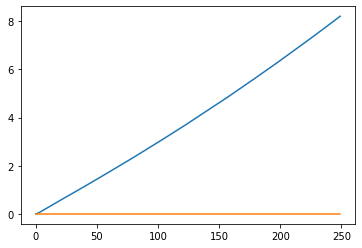

In [104]:
plt.plot(predicted_offset[:,0])
plt.plot(real_offset[:, 0])

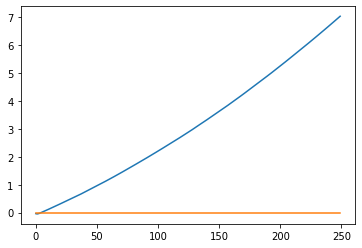

In [105]:
plt.plot(predicted_offset[:,1])
plt.plot(real_offset[:, 1])

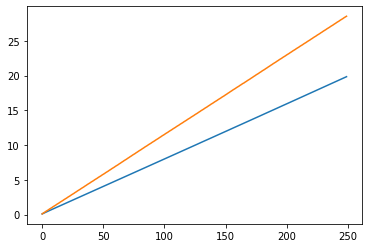

In [106]:
plt.plot(predicted_offset[:,2])
plt.plot(real_offset[:, 2])